In [1]:
source('../../helper/PRS_residuals_misc.R')
source('performance_plot_misc.R')

In [2]:
repo_root <- normalizePath('../../')
out_dir <- 'performance_plot'

In [3]:
dataset_list <- list(
    'snpnet_biomarker' = c('biomarkers_20190407')    
)

In [4]:
final_list <- fread(
    'list_of_phes.txt', head=FALSE
)
colnames(final_list) <- c('GBE_ID')


In [5]:
df <- dataset_list %>% read_all_data(repo_root) %>% 
inner_join(final_list, by='GBE_ID') %>% 
replace_na(list(Population = 'white_british')) %>%
select(-method, -PRS_model, -dataset_name, -dataset_version, -dataset_full)


In [6]:
df %>% dim() %>% print()
df %>% select(GBE_ID) %>% unique() %>% count() %>% print()


[1] 570   5
# A tibble: 1 x 1
      n
  <int>
1    38


### save data table

In [7]:
df_tabulated_full <- df %>% tabulate_df()

In [8]:
df_tabulated_full %>% select(
    -WB_delta_R_or_AUC, -WB_Genotype_and_covariates, -WB_Covariates_only, -WB_Genotype_only
) %>% 
fwrite(
    file.path(out_dir, 'snpnet_performance.tsv'), sep='\t'
)


### summary of performance reduction

In [9]:
df_tabulated_full %>% compute_performance_reduction()

Population,max,median,min,median_reduction
African,113.19690,28.03202,-Inf,71.967984
East Asian,85.92474,56.83065,-306.40175,43.169354
Non-British White,144.49656,93.64275,-11.81403,6.357245
South Asian,183.50089,69.96337,-31.23773,30.036629
White British,100.00000,100.00000,100.00000,0.000000


In [10]:
df_tabulated_full %>% 
filter(Population != 'White British') %>%
select(Phenotype, phe_type, Population, Relative_to_WB_delta_R_or_AUC, delta_R_or_AUC, WB_delta_R_or_AUC) %>% 
drop_na() %>%
# filter(delta_R_or_AUC >= 0) %>%
group_by(Population) %>% 
mutate(
    rank = rank(-as.numeric(Relative_to_WB_delta_R_or_AUC), ties.method="min")
) %>% ungroup() %>% filter(rank <= 3) %>% arrange(Population, rank)


Phenotype,phe_type,Population,Relative_to_WB_delta_R_or_AUC,delta_R_or_AUC,WB_delta_R_or_AUC,rank
Potassium in urine,qt,African,113.19690,0.00284860,0.0025165,1
Total bilirubin,qt,African,84.76735,0.28358450,0.3345445,2
Direct bilirubin,qt,African,77.65492,0.23230680,0.2991527,3
Albumin,qt,East Asian,85.92474,0.07784060,0.0905916,1
UACR,bin,East Asian,82.07646,0.00361120,0.0043998,2
Total protein,qt,East Asian,80.93086,0.12346990,0.1525622,3
Creatinine in urine,qt,Non-British White,144.49656,0.00434400,0.0030063,1
Sodium in urine,qt,Non-British White,144.36084,0.01062900,0.0073628,2
UACR,bin,Non-British White,105.11160,0.00462470,0.0043998,3
Potassium in urine,qt,South Asian,183.50089,0.00461780,0.0025165,1


### plots

In [11]:
p1 <- df %>% plot_bar_performance()


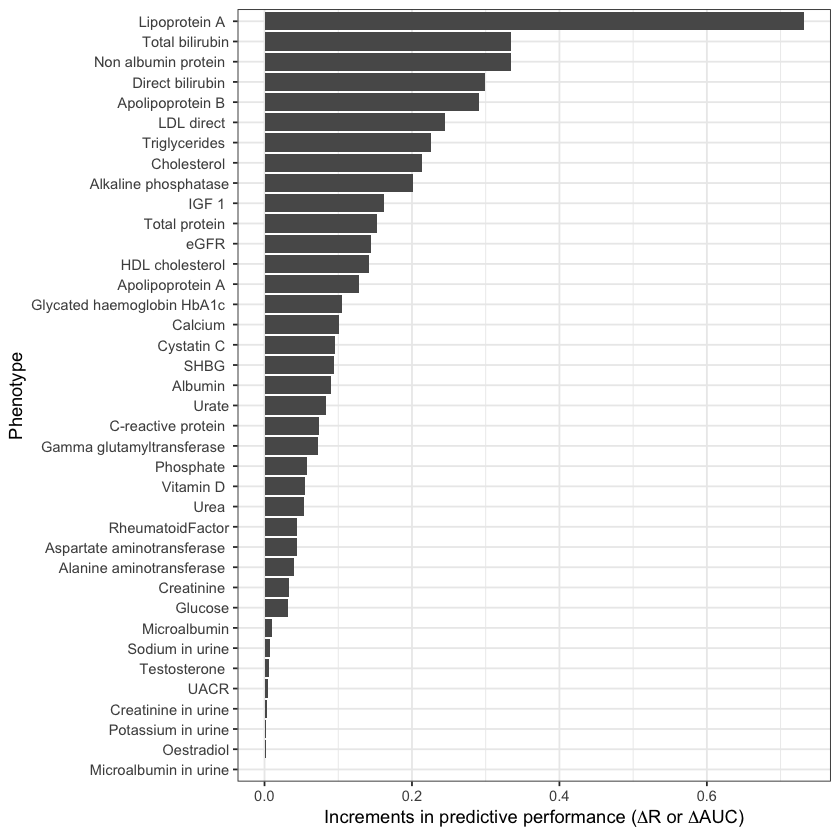

In [12]:
plot_width <- 7
plot_height <- 7
options(repr.plot.width=plot_width , repr.plot.height=plot_height)
p1
ggsave(file.path(out_dir, 'snpnet.png'), p1, width=plot_width, height=plot_height)

Warning message:
“Removed 9 rows containing missing values (geom_point).”Warning message:
“Removed 9 rows containing missing values (geom_text_repel).”

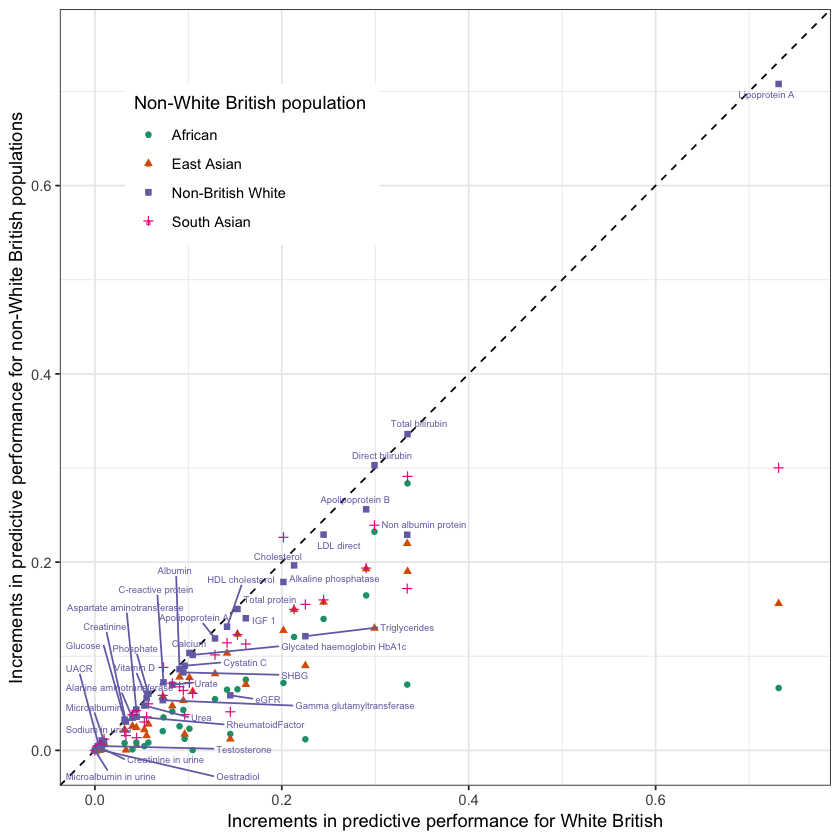

In [13]:
p2 <- df_tabulated_full %>% plot_trans_ethnic_delta()
p2

In [14]:
p2_in <- df_tabulated_full %>% 
filter(Population != 'White British') %>%
mutate(
    label_all = if_else(Population == 'Non-British White', Phenotype, ''),
    label = if_else(WB_delta_R_or_AUC < .5, label_all, '')
) %>%
rename(score = delta_R_or_AUC, WB_score = WB_delta_R_or_AUC) %>%
select(Phenotype, Population, score, WB_score, label) %>%
ggplot(aes(x = WB_score, y=score, color=Population, shape=Population, label=label))+ 
theme_bw() + 
theme(
    strip.text = element_text(size=7),
    legend.position = c(0.25, 0.6)
)+ 
geom_abline(slope=1, intercept=0, linetype = "dashed", alpha=.5) + 
geom_point(stat = 'identity') +
labs(
    x = 'Increments in predictive performance for White British',
    y = 'Increments in predictive performance for non-White British populations',
    color = 'Non-White British population',
    shape = 'Non-White British population'
) + 
ggrepel::geom_text_repel(size=2.5, force=3, segment.alpha=.4, xlim  = c(NA, .34), ylim  = c(NA, .34)) + 
scale_x_continuous(limits = c(0, .4), sec.axis = dup_axis(name = '')) +
scale_y_continuous(limits = c(0, .4), sec.axis = dup_axis(name = '')) +
scale_color_brewer(palette="Dark2")

Warning message:
“Removed 13 rows containing missing values (geom_point).”Warning message:
“Removed 13 rows containing missing values (geom_text_repel).”Warning message:
“Removed 13 rows containing missing values (geom_point).”Warning message:
“Removed 13 rows containing missing values (geom_text_repel).”Warning message:
“Removed 13 rows containing missing values (geom_point).”Warning message:
“Removed 13 rows containing missing values (geom_text_repel).”

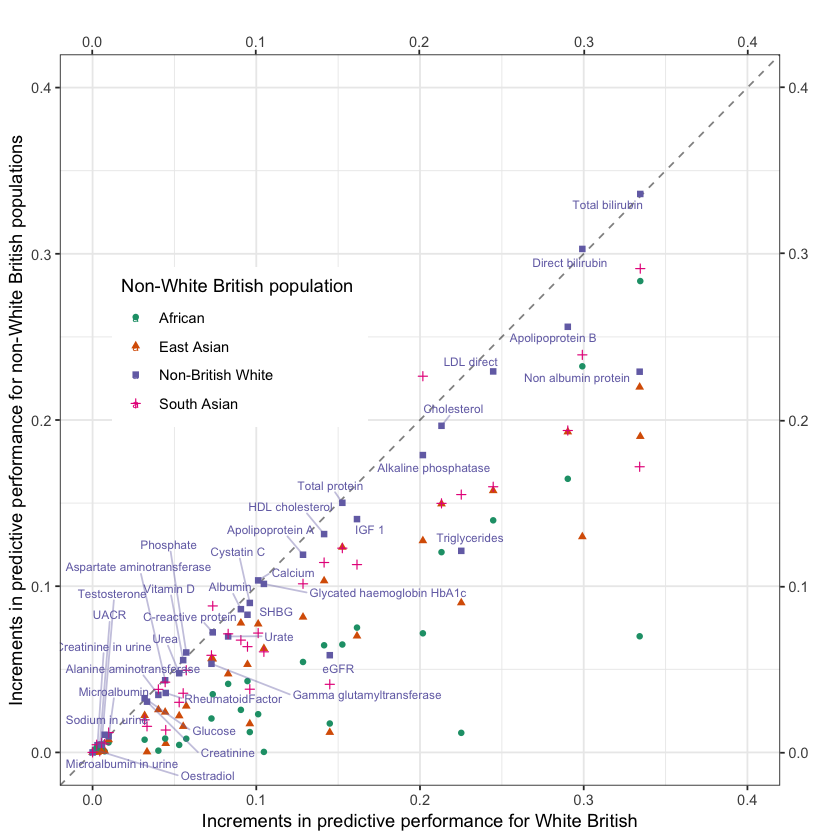

In [25]:
plot_width <- 7
plot_height <- 7
options(repr.plot.width=plot_width , repr.plot.height=plot_height)
p2_in
ggsave(file.path(out_dir, 'snpnet-multi-ethnic-delta-zoom-in.png'), width=plot_width, height=plot_height)
ggsave(file.path(out_dir, 'snpnet-multi-ethnic-delta-zoom-in.pdf'), width=plot_width, height=plot_height)

In [16]:
p2_out <- df_tabulated_full %>% 
filter(Population != 'White British') %>%
mutate(
    label_all = if_else(Population == 'Non-British White', Phenotype, ''),
    label = if_else(WB_delta_R_or_AUC > .5, label_all, '')
) %>%
rename(score = delta_R_or_AUC, WB_score = WB_delta_R_or_AUC) %>%
select(Phenotype, Population, score, WB_score, label) %>%
ggplot(aes(x = WB_score, y=score, color=Population, shape=Population, label=label))+ 
theme_bw() + 
theme(
    strip.text = element_text(size=7),
    legend.position = c(0.25, 0.6)
)+ 
geom_abline(slope=1, intercept=0, linetype = "dashed", alpha=.5) + 
geom_point(stat = 'identity') +
labs(
    x = 'Increments in predictive performance for White British',
    y = 'Increments in predictive performance for non-White British populations',
    color = 'Non-White British population',
    shape = 'Non-White British population'
) + 
ggrepel::geom_text_repel(size=2.5, force=3, segment.alpha=.4, xlim  = c(.72, NA), ylim  = c(.75, NA)) + 
scale_x_continuous(limits = c(0, .8), sec.axis = dup_axis(name = '')) +
scale_y_continuous(limits = c(0, .8), sec.axis = dup_axis(name = '')) +
scale_color_brewer(palette="Dark2")

Warning message:
“Removed 9 rows containing missing values (geom_point).”Warning message:
“Removed 9 rows containing missing values (geom_text_repel).”Warning message:
“Removed 9 rows containing missing values (geom_point).”Warning message:
“Removed 9 rows containing missing values (geom_text_repel).”Warning message:
“Removed 9 rows containing missing values (geom_point).”Warning message:
“Removed 9 rows containing missing values (geom_text_repel).”

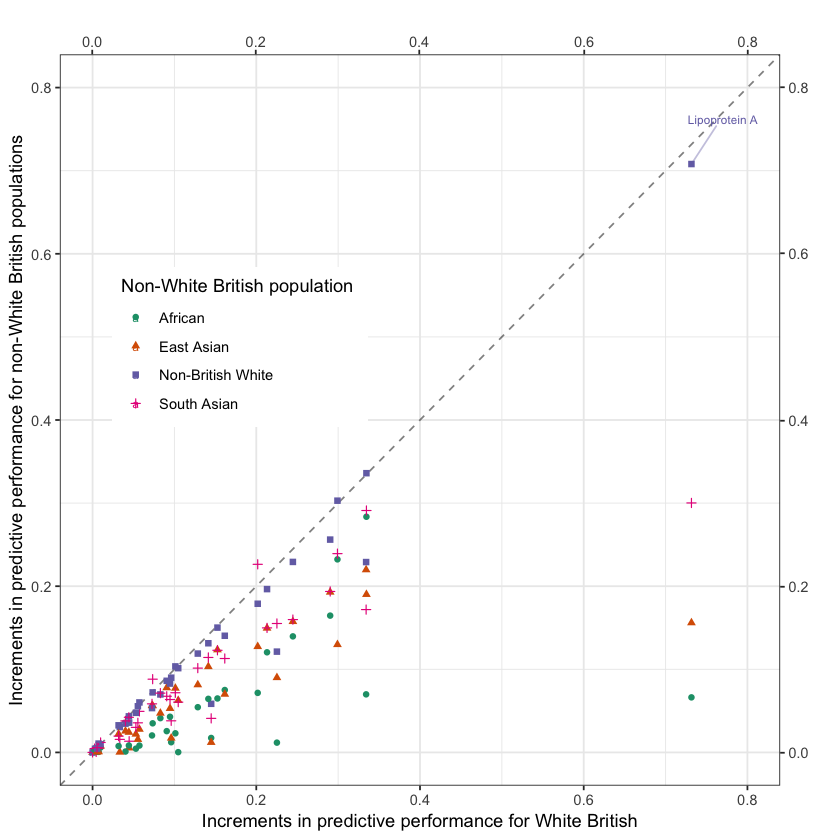

In [26]:
plot_width <- 7
plot_height <- 7
options(repr.plot.width=plot_width , repr.plot.height=plot_height)
p2_out
ggsave(file.path(out_dir, 'snpnet-multi-ethnic-delta.png'), width=plot_width, height=plot_height)
ggsave(file.path(out_dir, 'snpnet-multi-ethnic-delta.pdf'), width=plot_width, height=plot_height)

In [18]:
p3 <- df_tabulated_full %>% plot_trans_ethnic()


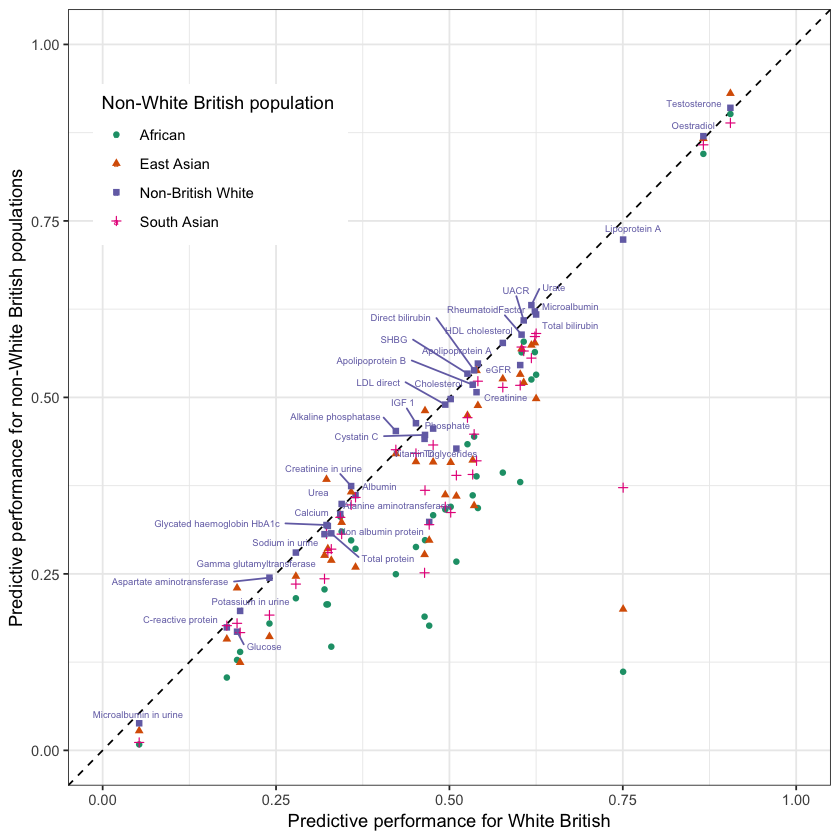

In [19]:
plot_width <- 7
plot_height <- 7
options(repr.plot.width=plot_width , repr.plot.height=plot_height)
p3
ggsave(file.path(out_dir, 'snpnet-multi-ethnic.png'), width=plot_width, height=plot_height)

### here is the status of the jobs

In [21]:
df %>% show_job_status(final_list)


Joining, by = "GBE_ID"


GBE_ID,african,e_asian,non_british_white,s_asian,white_british
Alanine_aminotransferase_adjstatins,1,1,1,1,1
Albumin_adjstatins,1,1,1,1,1
Alkaline_phosphatase,1,1,1,1,1
Apolipoprotein_A_adjstatins,1,1,1,1,1
Apolipoprotein_B_adjstatins,1,1,1,1,1
Aspartate_aminotransferase_adjstatins,1,1,1,1,1
Calcium_adjstatins,1,1,1,1,1
Cholesterol_adjstatins,1,1,1,1,1
C_reactive_protein_adjstatins,1,1,1,1,1
Creatinine_adjstatins,1,1,1,1,1


In [22]:
bias_df <- df %>% compute_delta() %>% format_labels() %>% filter(features == 'delta_R_or_AUC') %>% 
spread(Population, R_or_AUC) %>%
gather("Population", "R_or_AUC", c('White British', 'African', 'East Asian', 'South Asian', 'Non-British White')) %>%
group_by(GBE_ID)%>%
mutate(
    rank_R_or_AUC = rank(-R_or_AUC, ties.method="min"),
    rank_R_or_AUC = paste0('Rank_', rank_R_or_AUC)
) %>% ungroup() %>% count(Population, rank_R_or_AUC) %>% 
spread(rank_R_or_AUC, n, fill =0) %>% 
arrange(-Rank_1, -Rank_2, -Rank_3, -Rank_4, -Rank_5)

In [23]:
bias_df

Population,Rank_1,Rank_2,Rank_3,Rank_4,Rank_5
White British,23,14,1,0,0
Non-British White,11,18,7,2,0
South Asian,6,4,19,7,2
East Asian,1,0,8,22,7
African,0,1,2,6,29


In [24]:
bias_df %>% 
fwrite(file.path(out_dir, 'PRS_bias.tsv'), row.names=F, col.names=T, sep='\t')
